<a href="https://colab.research.google.com/github/andrespollano/neural_nets-tda/blob/main/MNIST/Sliding_window_TDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install giotto-tda
!pip install umap-learn
!pip install umap-learn[plot]
!pip install tensorflow
!pip install keras

In [2]:
import numpy as np
import pandas as pd
import gtda.diagrams as diag
from gtda.diagrams import Scaler, Filtering, PersistenceEntropy, BettiCurve, PairwiseDistance
from gtda.homology import VietorisRipsPersistence
import gtda.graphs as gr
from gtda.pipeline import Pipeline
from gtda.plotting import plot_point_cloud, plot_heatmap
from gtda.graphs import KNeighborsGraph, GraphGeodesicDistance
from gtda.mapper import (
    CubicalCover,
    OneDimensionalCover,
    make_mapper_pipeline,
    Projection,
    plot_static_mapper_graph,
    plot_interactive_mapper_graph)
from gtda.mapper import Eccentricity, Entropy

import umap.umap_ as umap

from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff

# Import datasets

In [3]:
#import scipy.io
from math import ceil
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from keras.datasets import mnist, cifar10, fashion_mnist
import tensorflow_datasets as tfds

In [4]:
# Convert emnist dataset to numpy arrays
def dataset_to_array(dataset):
    """
    Converts a tf.data.Dataset of images to a numpy array.
    """
    images = []

    # Iterate over the dataset
    for example in tfds.as_dataframe(dataset).to_dict('records'):
        # Extract the image and append it to the list
        images.append(example['image'])

    # Stack all images into a single numpy array and return it
    return np.stack(images)

# Extract labels from emnist dataset
def extract_labels(dataset):
    """
    Extracts labels from a tf.data.Dataset object and returns them as a numpy array.
    """
    labels = []
    for example in dataset:
        labels.append(example['label'])

    # Convert the list of labels to a numpy array and return it
    return np.array(labels)

def normalize_datapoints(x, factor):
  x = x.astype('float32') / factor
  return x

def random_shuffle(x, y):
  assert len(x) == len(y)
  p = np.random.permutation(len(x))
  return x[p], y[p]

def select_random_samples(data, n):
    # Get the total number of samples
    total_samples = data.shape[0]
    # Generate n random indices without replacement
    random_indices = np.random.choice(total_samples, n, replace=False)
    # Select the samples corresponding to the random indices
    random_samples = data[random_indices]

    return random_samples

# Create validation set
def three_way_split(x_train, y_train, x_test, y_test, shuffle=True, val_size=None, test_size=None):

  x = np.append(x_train, x_test, axis=0)
  y = np.append(y_train, y_test, axis=0)

  if shuffle:
    x, y = random_shuffle(x, y)

  if test_size is None:
    test_size = len(x_test)
  if val_size is None:
    val_size = len(x_test)

  x_train_spl, x_test, y_train_spl, y_test = train_test_split(x, y, test_size=test_size)
  if val_size > 0:
    x_train, x_val, y_train, y_val = train_test_split(x_train_spl, y_train_spl, test_size=val_size)
  else:
    x_train, y_train = x_train_spl, y_train_spl
    x_val, y_val = np.empty(x_train.shape), np.empty(y_train.shape)

  return (x_train, y_train), (x_val, y_val), (x_test, y_test)

def import_dataset(dataset, shuffle=True, val_size=None, test_size=None):
  x_train, y_train, x_test, y_test = None, None, None, None

  if dataset == 'mnist':
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.reshape(len(x_train), 28, 28, 1)
    x_test = x_test.reshape(len(x_test), 28, 28, 1)
  elif dataset == 'cifar10':
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

  elif dataset == 'fashion_mnist':
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    x_train = x_train.reshape(len(x_train), 28, 28, 1)
    x_test = x_test.reshape(len(x_test), 28, 28, 1)

  elif dataset == 'emnist':
    emnist_data = tfds.load('emnist/letters')
    x_train, x_test = emnist_data['train'], emnist_data['test']
    # Extract labels for the training and test datasets
    y_train = extract_labels(x_train)
    y_test = extract_labels(x_test)
    # Convert the train and test datasets to numpy arrays
    x_train = dataset_to_array(x_train)
    x_test = dataset_to_array(x_test)

  x_train = normalize_datapoints(x_train, 255. )
  x_test = normalize_datapoints(x_test, 255. )

  (x_train, y_train), (x_val, y_val), (x_test, y_test) = three_way_split(x_train, y_train, x_test, y_test, shuffle, val_size, test_size)

  return (x_train, y_train), (x_val, y_val), (x_test, y_test)

# Perform image perturbations.
def image_generator(x, orig_dims, rot_range, width_range, height_range, shear_range, zoom_range, horizontal_flip, vertical_flip, delta=1.0):
    indices = np.random.choice(x.shape[0], ceil(x.shape[0] * delta), replace=False)
    datagen = ImageDataGenerator(rotation_range=rot_range,
                                 width_shift_range=width_range,
                                 height_shift_range=height_range,
                                 shear_range=shear_range,
                                 zoom_range=zoom_range,
                                 horizontal_flip=horizontal_flip,
                                 vertical_flip=vertical_flip,
                                 fill_mode="nearest")
    x_mod = x[indices, :]
    for idx in range(len(x_mod)):
        img_sample = x_mod[idx, :].reshape(orig_dims)
        mod_img_sample = datagen.flow(np.array([img_sample]), batch_size=1)[0]
        x_mod[idx, :] = mod_img_sample.reshape(np.prod(mod_img_sample.shape))
    x[indices, :] = x_mod

    return x, indices

def apply_shift(X_te_orig, y_te_orig, shift, orig_dims, dataset):

  orig_dims = X_te_orig.shape[1:]

  # Reshape to matrix form
  X_te_orig = X_te_orig.reshape((len(X_te_orig), np.prod(X_te_orig.shape[1:])))
  y_te_orig = y_te_orig.reshape(len(y_te_orig))

  X_te_1 = None
  y_te_1 = None

  if shift == 'small_img_shift_0.1':
    print('Small image shift')
    X_te_1, _ = image_generator(X_te_orig, orig_dims, 10, 0.05, 0.05, 0.1, 0.1, False, False, delta=0.1)
    y_te_1 = y_te_orig.copy()
  elif shift == 'small_img_shift_0.5':
    print('Small image shift')
    X_te_1, _ = image_generator(X_te_orig, orig_dims, 10, 0.05, 0.05, 0.1, 0.1, False, False, delta=0.5)
    y_te_1 = y_te_orig.copy()
  elif shift == 'small_img_shift_1.0':
    print('Small image shift')
    X_te_1, _ = image_generator(X_te_orig, orig_dims, 10, 0.05, 0.05, 0.1, 0.1, False, False, delta=1.0)
    y_te_1 = y_te_orig.copy()
  elif shift == 'medium_img_shift_0.1':
    print('Medium image shift')
    X_te_1, _ = image_generator(X_te_orig, orig_dims, 40, 0.2, 0.2, 0.2, 0.2, True, False, delta=0.1)
    y_te_1 = y_te_orig.copy()
  elif shift == 'medium_img_shift_0.5':
    print('Medium image shift')
    X_te_1, _ = image_generator(X_te_orig, orig_dims, 40, 0.2, 0.2, 0.2, 0.2, True, False, delta=0.5)
    y_te_1 = y_te_orig.copy()
  elif shift == 'medium_img_shift_1.0':
    print('Medium image shift')
    X_te_1, _ = image_generator(X_te_orig, orig_dims, 40, 0.2, 0.2, 0.2, 0.2, True, False, delta=1.0)
    y_te_1 = y_te_orig.copy()
  elif shift == 'large_img_shift_0.1':
    print('Large image shift')
    X_te_1, _ = image_generator(X_te_orig, orig_dims, 90, 0.4, 0.4, 0.3, 0.4, True, True, delta=0.1)
    y_te_1 = y_te_orig.copy()
  elif shift == 'large_img_shift_0.5':
    print('Large image shift')
    X_te_1, _ = image_generator(X_te_orig, orig_dims, 90, 0.4, 0.4, 0.3, 0.4, True, True, delta=0.5)
    y_te_1 = y_te_orig.copy()
  elif shift == 'large_img_shift_1.0':
    print('Large image shift')
    X_te_1, _ = image_generator(X_te_orig, orig_dims, 90, 0.4, 0.4, 0.3, 0.4, True, True, delta=1.0)
    y_te_1 = y_te_orig.copy()

  return (X_te_1, y_te_1)

In [5]:
# MNIST dataset
val_size = 20000
test_size = 20000
(x_train_mnist, y_train_mnist), (x_val_mnist, y_val_mnist), (x_test_mnist, y_test_mnist) = import_dataset('mnist', val_size=val_size, test_size=test_size)
print(f'Train size: {len(x_train_mnist)}')
print(f'Validation size: {len(x_val_mnist)}')
print(f'Test size: {len(x_test_mnist)}')

11490434/11490434 [==============================] - 0s 0us/step
Train size: 30000
Validation size: 20000
Test size: 20000


In [6]:
# Fashion MNIST dataset
val_size = 20000
test_size = 40000
(x_train_fmnist, y_train_fmnist), (x_val_fmnist, y_val_fmnist), (x_test_fmnist, y_test_fmnist) = import_dataset('fashion_mnist', val_size=val_size, test_size=test_size)
print(f'Train size: {len(x_train_fmnist)}')
#print(f'Validation size: {len(x_val_fmnist)}')
print(f'Test size: {len(x_test_fmnist)}')

4422102/4422102 [==============================] - 0s 0us/step
Train size: 10000
Test size: 40000


In [ ]:
# EMNIST dataset
val_size = 1000
test_size = 60000
(x_train_emnist, y_train_emnist), (x_val_emnist, y_val_emnist), (x_test_emnist, y_test_emnist) = import_dataset('emnist', val_size=val_size, test_size=test_size)
print(f'Train size: {len(x_train_emnist)}')
#print(f'Validation size: {len(x_val_fmnist)}')
print(f'Test size: {len(x_test_emnist)}')

In [ ]:
# Generate datasets with a proportion (delta) of OOD samples
n_samples = 5000
deltas = [0.01, 0.05, 0.1, 0.2, 0.5] # proportion of OOD samples

ood_datasets = {}

for delta in deltas:
  mnist_prop = 1 - delta
  n_mnist = n_samples * mnist_prop
  n_ood = n_samples * delta

  mnist_samples = select_random_samples(x_test_mnist, int(n_mnist))
  fmnist_samples = select_random_samples(x_test_fmnist, int(n_ood/2))
  emnist_samples = select_random_samples(x_test_emnist, int(n_ood/2))

  combined_array = np.concatenate([mnist_samples, fmnist_samples, emnist_samples], axis=0)
  np.random.shuffle(combined_array)

  ood_datasets[f'mnist_{delta}'] = combined_array


# Train Model

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical

In [8]:
# Preprocess the data
n_classes = len(np.unique(y_train_mnist))

#x_train_mnist = x_train_mnist.reshape(x_train_mnist.shape[0], 28, 28, 1).astype('float32') / 255
#x_val_mnist = x_test_mnist.reshape(x_val_mnist.shape[0], 28, 28, 1).astype('float32') / 255

y_train_mnist = to_categorical(y_train_mnist, n_classes)
y_val_mnist = to_categorical(y_val_mnist, n_classes)

# Define the model
inputs = Input(shape=(28, 28, 1))

x = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)

x = Dense(128, activation='relu')(x)
last_hidden_layer_output = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(last_hidden_layer_output)

model = Model(inputs=inputs, outputs=predictions)

# Define a model that outputs the last hidden layer
hidden_model = Model(inputs=model.input, outputs=last_hidden_layer_output)

In [9]:
model_weights_file = 'model_weights (1).h5'
hidden_model_weights_file = 'hidden_model_weights (1).h5'

try:
  # load weights if file exist
  model.load_weights(model_weights_file)
  hidden_model.load_weights(hidden_model_weights_file)

except FileNotFoundError:
  # Compile the model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Train the model
  model.fit(x_train_mnist, y_train_mnist, batch_size=128, epochs=10, verbose=1, validation_data=(x_val_mnist, y_val_mnist))

  # Save model weights
  model.save_weights(model_weights_file)

  # Save weights for the hidden_model
  hidden_model.save_weights(hidden_model_weights_file)

# Generate hiddel layer outputs

In [10]:
# Get last hidden layer representation for MNIST and Fashion-MNIST
hidden_outputs_mnist = hidden_model.predict(x_test_mnist)
hidden_outputs_fashion = hidden_model.predict(x_test_fmnist)
#hidden_outputs_emnist = hidden_model.predict(x_test_emnist)

1250/1250 [==============================] - 16s 13ms/step


In [29]:
y_test_mnist.shape

(20000,)

In [ ]:
# Generate last hidden layer represendation for distorted MNIST data
datasets = {'mnist' : hidden_outputs_mnist, 'fmnist': hidden_outputs_fashion, 'emnist': hidden_outputs_emnist}

for ood_name, ood_dataset in ood_datasets.items():
  hidden_outputs = hidden_model.predict(ood_dataset)
  datasets[ood_name] = hidden_outputs

for name, hidden_outputs in datasets.items():
    print(name, hidden_outputs.shape)

#hidden_outputs_mnist.shape, hidden_outputs_fashion.shape, hidden_outputs_emnist.shape

In [11]:
y_test_mnist

array([4, 2, 9, ..., 1, 9, 9], dtype=uint8)

In [46]:
import numpy as np

# Generate sliding windows for 0's and 1's
n_examples = 200

zero_indices = np.flatnonzero(y_test_mnist == 0)[:n_examples]
one_indices = np.flatnonzero(y_test_mnist == 1)[:n_examples]

selected_indices = np.concatenate([zero_indices, one_indices])

# Extract the corresponding feature vectors and labels
selected_features = hidden_outputs_mnist[selected_indices]
selected_labels = y_test_mnist[selected_indices]
selected_labels.shape

(400,)

In [36]:
# Generate point cloud
def sliding_window_point_cloud(vector, window_size, step_size=1):
    # Check that the window size is smaller than the vector size
    if window_size > len(vector):
        raise ValueError("Window size must be smaller than vector size.")

    # Slide the window across the vector, extracting subvectors
    point_cloud = [vector[i:i+window_size] for i in range(0, len(vector) - window_size + 1, step_size)]

    return np.array(point_cloud)

#point_cloud = sliding_window_point_cloud(selected_features[0], 10)
#point_cloud.shape

(119, 10)

# Generate topological features

In [33]:
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import Amplitude, PersistenceEntropy
from sklearn.pipeline import make_pipeline, make_union

homology_dimensions = [0,1,2,3]
# Select a variety of metrics to calculate amplitudes
amplitude_metrics = ["bottleneck", "wasserstein"]

def generate_topological_features(hidden_layer_data):
  # Generate diagrams
  persistence = VietorisRipsPersistence(
      metric="euclidean",
      homology_dimensions=homology_dimensions,
      collapse_edges=True,
  )

  diagrams = persistence.fit_transform(hidden_layer_data)

  metrics = [
    {"metric": metric}
    for metric in amplitude_metrics
  ]

  # Generate features
  feature_union = make_union(
      *[PersistenceEntropy(nan_fill_value=-1)]
      + [Amplitude(**metric, n_jobs=-1) for metric in metrics]
  )

  tda_features = feature_union.fit_transform(diagrams)

  # print(f' {tda_features.shape[1]} features created for {tda_features.shape[0]} point cloud')

  return tda_features

def generate_feature_names():
  # Names of the persistence entropy features
  persistence_entropy_feature_names = [f'persistence_entropy_dim_{dim}' for dim in homology_dimensions]

  # Names of the amplitude features
  amplitude_feature_names = [f'amplitude_{metric}_dim_{dim}' for metric in amplitude_metrics for dim in homology_dimensions]

  # Combining all feature names
  feature_names = persistence_entropy_feature_names + amplitude_feature_names

  return feature_names

In [ ]:
def split_data(data, chunk_size):
    # Calculate the number of chunks
    n_chunks = len(data) // chunk_size

    # Split the data into chunks of size n, and discard the last chunk if the array size is not divisible by n
    chunks = [data[i * chunk_size : (i + 1) * chunk_size] for i in range(n_chunks)]

    return chunks

In [61]:
# For each instance, generate sliding window point cloud (), generate top features, append
window_size = 10
columns = generate_feature_names()
point_could_features = pd.DataFrame(columns=columns)
point_could_labels = pd.DataFrame(columns=['dataset'])

for idx, instance in enumerate(selected_features):
  point_cloud = sliding_window_point_cloud(instance, window_size)
  point_cloud = point_cloud.reshape(1, *point_cloud.shape)
  tda_features = generate_topological_features(point_cloud) # array (1,9)
  point_could_features.loc[idx] = tda_features[0] # Append instance
  point_could_labels.loc[idx] = selected_labels[idx]

point_could_features.shape

(400, 12)

# Cluster and Visualise

In [ ]:
tda_features_file = 'tda_features (2).pkl'
tda_labels_file = 'tda_labels (1).pkl'

point_could_features = pd.read_pickle(tda_features_file)
point_could_labels = pd.read_pickle(tda_labels_file)

In [40]:
point_could_features

,persistence_entropy_dim_0,persistence_entropy_dim_1,persistence_entropy_dim_2,persistence_entropy_dim_3,amplitude_bottleneck_dim_0,amplitude_bottleneck_dim_1,amplitude_bottleneck_dim_2,amplitude_bottleneck_dim_3,amplitude_wasserstein_dim_0,amplitude_wasserstein_dim_1,amplitude_wasserstein_dim_2,amplitude_wasserstein_dim_3
0,6.711593,5.512788,4.282788,0.000000,2.455447,0.449714,0.218969,0.012857,14.158704,1.608499,0.576789,0.012857
1,6.741337,4.574995,0.872221,-1.000000,2.803193,0.453127,0.017013,0.000000,14.166426,1.306939,0.018413,0.000000
2,6.745290,5.201508,2.566346,-1.000000,2.390182,0.444438,0.058967,0.000000,14.372967,1.100743,0.095895,0.000000
3,6.639865,3.478526,-1.000000,-1.000000,1.700425,0.515287,0.000000,0.000000,9.042716,0.930659,0.000000,0.000000
4,6.793562,5.631909,3.786402,1.709521,2.368118,0.802450,0.257750,0.105160,16.414308,2.198452,0.569783,0.130458
5,6.666579,5.068598,3.516668,1.426107,1.798618,0.354035,0.088949,0.063971,9.584787,1.027583,0.183282,0.073656
6,6.789672,5.261443,2.783235,0.000000,1.383395,0.301052,0.031842,0.091442,8.785484,0.773646,0.059448,0.091442
7,6.750670,5.641334,2.524181,0.000000,1.681730,0.243610,0.162983,0.010161,9.990161,0.788062,0.191594,0.010161
8,6.672338,5.329178,3.945927,2.339347,1.866633,0.258675,0.188514,0.079085,10.496622,0.946568,0.326120,0.117471
9,6.783318,5.123027,2.472767,0.000000,1.581975,0.274587,0.062111,0.002913,9.628190,0.874668,0.080559,0.002913


In [41]:
point_could_labels

,dataset
0,0
1,0
2,0
3,0
4,0
5,1
6,1
7,1
8,1
9,1


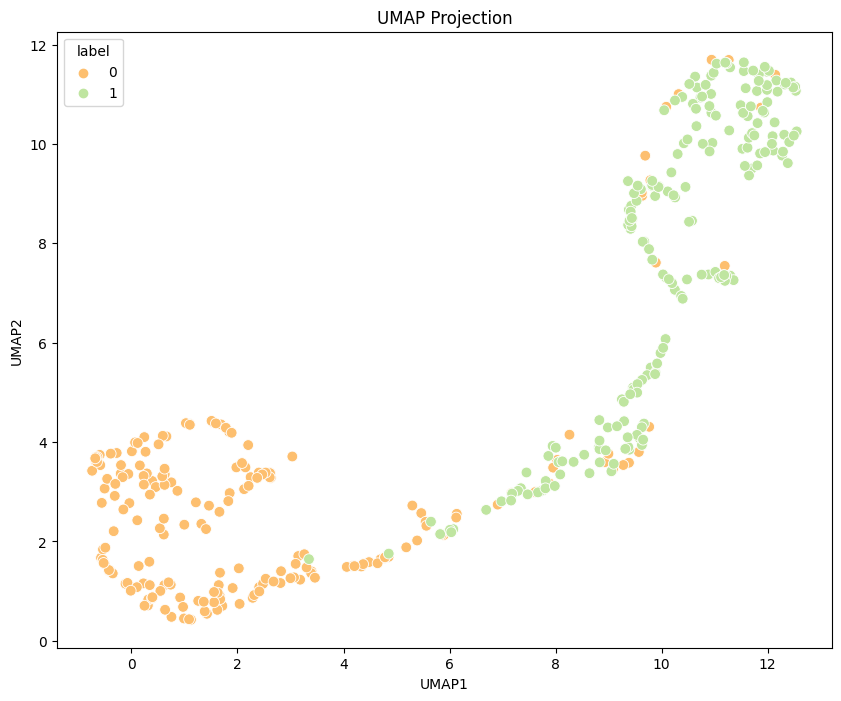

In [62]:
import seaborn as sns

# Assuming features_df is your DataFrame of shape (140, 9) and labels_df is your DataFrame of shape (140, 1)
features_df = point_could_features
labels_df = point_could_labels

# Combine the features and labels
data_with_labels = pd.concat([features_df, labels_df], axis=1)
data_with_labels.columns = list(features_df.columns) + ['label']

# Fit UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(features_df)

# Create a DataFrame with the UMAP results
umap_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
umap_df['label'] = labels_df.values

# Plot the UMAP results
plt.figure(figsize=[10,8])
sns.scatterplot(x='UMAP1', y='UMAP2', hue='label', data=umap_df, palette='Spectral', s=60)
plt.title('UMAP Projection')
plt.show()

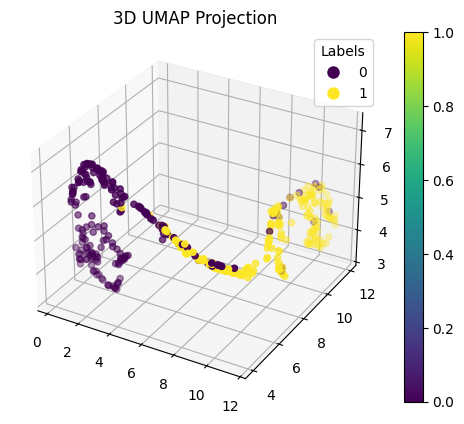

In [49]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from mpl_toolkits.mplot3d import Axes3D

# Assuming features_df is your DataFrame of shape (140, 9) and labels_df is your DataFrame of shape (140, 1)
features_df = point_could_features
labels_df = point_could_labels

# Assuming features_df and labels_df are already defined
features = features_df.values
labels = labels_df.values.ravel()

# Encode the labels as integers
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

# Map the encoded labels back to original labels
label_mapping = {i: label for i, label in enumerate(encoder.classes_)}

# Create UMAP transformer with 3 components for 3D projection
umap_transformer = umap.UMAP(n_components=3)

# Fit and transform the data
umap_embedding = umap_transformer.fit_transform(features)

# Create a scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(umap_embedding[:, 0], umap_embedding[:, 1], umap_embedding[:, 2], c=encoded_labels, cmap='viridis')

# Add a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(i / (len(label_mapping) - 1)), markersize=10) for i in range(len(label_mapping))]
ax.legend(handles, label_mapping.values(), title='Labels')

plt.colorbar(scatter, ax=ax)
plt.title('3D UMAP Projection')
plt.show()

In [ ]:
from scipy.spatial.distance import euclidean
import numpy as np

# Define cluster and non-cluster instances
features_df = point_could_features.copy()
labels_df = point_could_labels.copy()

mnist_indices = labels_df[labels_df['dataset'] == 'mnist'].index
mnist_features = features_df.loc[mnist_indices].values
non_cluster_features = features_df.drop(mnist_indices).values
test_cluster_features = mnist_val_features.values



#cluster_instances = cluster_df.values # Assuming cluster_df is the DataFrame with 20 instances and 9 features
#non_cluster_instances = non_cluster_df.values # 150 non-cluster instances

# Compute the centroid of the cluster
centroid = np.mean(mnist_features, axis=0)

# Define a function to classify a point based on distance threshold
def classify_point(point, threshold):
    distance = euclidean(point, centroid)
    return distance > threshold

# Find the threshold that maximizes accuracy on non-cluster instances and test_cluster_instances
best_accuracy = 0
best_threshold = 0
for threshold in np.linspace(0, 50, 10000):
    # Check non-cluster instances (should be outside the cluster)
    non_cluster_predictions = [classify_point(point, threshold) for point in non_cluster_features]
    non_cluster_accuracy = sum(non_cluster_predictions) / len(non_cluster_predictions)

    # Check test_cluster_instances (should be inside the cluster)
    test_cluster_predictions = [not classify_point(point, threshold) for point in test_cluster_features]
    test_cluster_accuracy = sum(test_cluster_predictions) / len(test_cluster_predictions)

    # Compute overall accuracy
    accuracy = (non_cluster_accuracy + test_cluster_accuracy) / 2

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

print("Best Threshold:", best_threshold)
print("Best Accuracy:", best_accuracy)

Best Threshold: 10.716071607160716
Best Accuracy: 0.9103448275862069


In [ ]:
threshold = 10.716071607160716
# Check non-cluster instances (should be outside the cluster)
non_cluster_predictions = [classify_point(point, threshold) for point in non_cluster_features]
non_cluster_accuracy = sum(non_cluster_predictions) / len(non_cluster_predictions)

# Check test_cluster_instances (should be inside the cluster)
test_cluster_predictions = [not classify_point(point, threshold) for point in test_cluster_features]
test_cluster_accuracy = sum(test_cluster_predictions) / len(test_cluster_predictions)

print(f'OOD accuracy: {non_cluster_accuracy}')
print(f'ID accuracy: {test_cluster_accuracy}')

OOD accuracy: 0.8206896551724138
ID accuracy: 1.0


In [ ]:
# Concatenate the datasets
all_data = np.concatenate([mnist_features, non_cluster_features, test_cluster_features])

# Apply UMAP to the concatenated data
reducer = umap.UMAP(n_components=4)
all_data_reduced = reducer.fit_transform(all_data)

# Split the reduced data back into the original datasets
mnist_features_reduced, non_cluster_features_reduced, test_cluster_features_reduced = np.split(all_data_reduced, [len(mnist_features), len(mnist_features) + len(non_cluster_features)])

# Compute the centroid of the cluster
centroid = np.mean(mnist_features_reduced, axis=0)

# Define a function to classify a point based on distance threshold
def classify_point(point, threshold):
    distance = euclidean(point, centroid)
    return distance > threshold

# Find the threshold that maximizes accuracy on non-cluster instances and test_cluster_instances
best_accuracy = 0
best_threshold = 0
for threshold in np.linspace(0, 50, 1000):
    # Check non-cluster instances (should be outside the cluster)
    non_cluster_predictions = [classify_point(point, threshold) for point in non_cluster_features_reduced]
    non_cluster_accuracy = sum(non_cluster_predictions) / len(non_cluster_predictions)

    # Check test_cluster_instances (should be inside the cluster)
    test_cluster_predictions = [not classify_point(point, threshold) for point in test_cluster_features_reduced]
    test_cluster_accuracy = sum(test_cluster_predictions) / len(test_cluster_predictions)

    # Compute overall accuracy
    accuracy = (non_cluster_accuracy + test_cluster_accuracy) / 2

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

print("Best Threshold:", best_threshold)
print("Best Accuracy:", best_accuracy)

Best Threshold: 12.412412412412413
Best Accuracy: 0.9137931034482758


In [ ]:
threshold = 12.412412412412413
# Check non-cluster instances (should be outside the cluster)
non_cluster_predictions = [classify_point(point, threshold) for point in non_cluster_features_reduced]
non_cluster_accuracy = sum(non_cluster_predictions) / len(non_cluster_predictions)

# Check test_cluster_instances (should be inside the cluster)
test_cluster_predictions = [not classify_point(point, threshold) for point in test_cluster_features_reduced]
test_cluster_accuracy = sum(test_cluster_predictions) / len(test_cluster_predictions)

print(f'OOD accuracy: {non_cluster_accuracy}')
print(f'ID accuracy: {test_cluster_accuracy}')

OOD accuracy: 0.8275862068965517
ID accuracy: 1.0
